In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle


from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

# Warum auch immer, bekomme ich einen fehler wenn ich das hier nicht drinne habe. 
config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.85
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [2]:
# Download a super large dataset
# 13 GB von trainingsdaten 80k
# Download caption annotation files
annotation_folder = '/annotations/'
if not os.path.exists(os.path.abspath('.') + annotation_folder):
    annotation_zip = tf.keras.utils.get_file('captions.zip', cache_subdir=os.path.abspath('.'), origin = 'http://images.cocodataset.org/annotations/annotations_trainval2014.zip', extract = True)
    annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json' 
    os.remove(annotation_zip)
else:
    annotation_file = os.path.abspath('.') + annotation_folder +'/captions_train2014.json' 

# Download image files
image_folder = '/train2014/'
if not os.path.exists(os.path.abspath('.') + image_folder):
    image_zip = tf.keras.utils.get_file('train2014.zip', cache_subdir=os.path.abspath('.'), origin = 'http://images.cocodataset.org/zips/train2014.zip', extract = True)
    PATH = os.path.dirname(image_zip) + image_folder
    os.remove(image_zip)
else:
    PATH = os.path.abspath('.') + image_folder

In [3]:
# limitiren der daten im ram, da es nicht alles rein passt
# Read the json file
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

# Bilder namen und Beschreibungen
all_captions = []
all_img_name_vector = []

for annot in annotations['annotations']:
    caption = '<start> ' + annot['caption'] + ' <end>'
    image_id = annot['image_id']
    full_coco_image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (image_id)

    all_img_name_vector.append(full_coco_image_path)
    all_captions.append(caption)

train_captions, img_name_vector = shuffle(all_captions, all_img_name_vector, random_state=1)

# Aus Performancegründe nur 30k
num_examples = 30000
train_captions = train_captions[:num_examples]
img_name_vector = img_name_vector[:num_examples]

len(train_captions), len(all_captions)

(30000, 414113)

In [4]:
# Verwenden von InceptionV3 was darauf trainiert wurde Bilder zu klassifizieren
# Dafür müssen die Bilder vorbereitet werden
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

In [5]:
image_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

In [6]:
# Da die Trainingsdatei relativ groß ist, müssen wir Cachen da nicht alles in den RAM passt.
# Theoretisch genug vorhanden, aber nicht alle Trainingsdaten bleiben so klein

encode_train = sorted(set(img_name_vector))

image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

for img, path in image_dataset:
    batch_features = image_features_extract_model(img)
    batch_features = tf.reshape(batch_features, (batch_features.shape[0], -1, batch_features.shape[3]))

    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        np.save(path_of_feature, bf.numpy())

In [7]:
# Für viele Modelle sind immer die max längen wichtig!

def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [8]:
# Wir nehmen nur die wichtigsten 5k wörter, der rest ist UKN

top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k, oov_token="<unk>", filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)

tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(train_captions)

# zur max length maxxen
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

max_length = calc_max_length(train_seqs)

# train test split
img_name_train, img_name_val, cap_train, cap_val = train_test_split(img_name_vector, cap_vector, test_size=0.2, random_state=0)

len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(24000, 24000, 6000, 6000)

In [9]:
# Training settings here *

BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = top_k + 1
num_steps = len(img_name_train) // BATCH_SIZE
# InceptionV3 parameter
features_shape = 2048
attention_features_shape = 64

In [10]:
def map_func(img_name, cap):
    img_tensor = np.load(img_name.decode('utf-8')+'.npy')
    return img_tensor, cap

In [11]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(map_func, [item1, item2], [tf.float32, tf.int32]), num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [25]:
# Copy Catty des selben Modells wie bereits des übersetzer Modells
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

        # hidden shape == (batch_size, hidden_size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        # attention_hidden_layer shape == (batch_size, 64, units)
        attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                             self.W2(hidden_with_time_axis)))

        # score shape == (batch_size, 64, 1)
        # This gives you an unnormalized score for each image feature.
        score = self.V(attention_hidden_layer)

        # attention_weights shape == (batch_size, 64, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights
    
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x
    
class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units

        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.units)

    def call(self, x, features, hidden):
        # defining attention as a separate model
        context_vector, attention_weights = self.attention(features, hidden)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # passing the concatenated vector to the GRU
        output, state = self.gru(x)

        # shape == (batch_size, max_length, hidden_size)
        x = self.fc1(output)

        # x shape == (batch_size * max_length, hidden_size)
        x = tf.reshape(x, (-1, x.shape[2]))

        # output shape == (batch_size * max_length, vocab)
        x = self.fc2(x)

        return x, state, attention_weights

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))


In [26]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

checkpoint_path = "./checkpoints/Img_caption"
ckpt = tf.train.Checkpoint(encoder=encoder, decoder=decoder, optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
    # restoring the latest checkpoint in checkpoint_path
    ckpt.restore(ckpt_manager.latest_checkpoint)

In [27]:
loss_plot = []

In [28]:
@tf.function
def train_step(img_tensor, target):
    loss = 0

    # initializing the hidden state for each batch
    # because the captions are not related from image to image
    hidden = decoder.reset_state(batch_size=target.shape[0])

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
            # passing the features through the decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)

            loss += loss_function(target[:, i], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = (loss / int(target.shape[1]))

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss

In [ ]:
EPOCHS = 10 # More epochs = crashes :( OOM, ist insgesamt das sechste mal, dass ich es versuche. Mein System ist einfach zu schlecht

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
            
    loss_plot.append(total_loss / num_steps)

    #if epoch % 2 == 0: # habe bereits einmal mehr epochen geschafft.
    #    ckpt_manager.save()

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1, total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

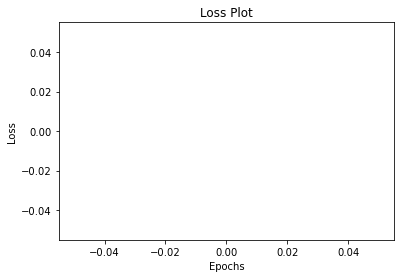

In [24]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [18]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [19]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

Beschreibung: <start> a street sign is hanging on a pole <end>
Was passen könnte: the stop sign depicts a sign atop a sign on it pole of it <end>


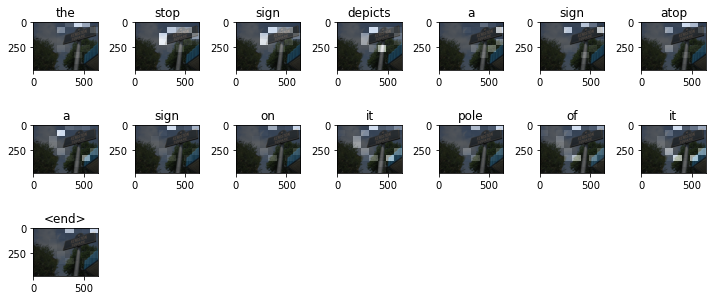

In [20]:
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print ('Beschreibung:', real_caption)
print ('Was passen könnte:', ' '.join(result))
plot_attention(image, result, attention_plot)